In [1]:
"""
Analyse merged data from EU database (output from 1_2-prep_database_file_merger)
For now we only use *.csv export from EU database
"""

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline
from config import MERGED_DATA_FILE, DATABASE_FILE_DTYPES, DATABASE_FILE_INDEX, UNIQUE_VALUES_THRESHOLD, OUTPUT_DIR

In [2]:
df = pd.read_csv(MERGED_DATA_FILE, dtype=DATABASE_FILE_DTYPES, index_col=DATABASE_FILE_INDEX)

In [3]:
print(f"Dimension: {df.shape}")
print(f"Columns: {df.columns}")
print(f"Data types:\n{df.dtypes}")

Dimension: (10734898, 18)
Columns: Index(['member_state', 'manufacturer_name_eu', 'vehicle_type',
       'commercial_name', 'category_of_vehicle', 'fuel_type', 'fuel_mode',
       'innovative_technologies', 'mass_vehicle', 'weltp_test_mass',
       'engine_capacity', 'engine_power', 'erwltp', 'year', 'electric_range',
       'electric_energy_consumption', 'fuel_consumption',
       'specific_co2_emissions'],
      dtype='object')
Data types:
member_state                    object
manufacturer_name_eu            object
vehicle_type                    object
commercial_name                 object
category_of_vehicle             object
fuel_type                       object
fuel_mode                       object
innovative_technologies         object
mass_vehicle                   float64
weltp_test_mass                float64
engine_capacity                float64
engine_power                   float64
erwltp                         float64
year                             int64
electric

In [4]:
df.head(2)

,member_state,manufacturer_name_eu,vehicle_type,commercial_name,category_of_vehicle,fuel_type,fuel_mode,innovative_technologies,mass_vehicle,weltp_test_mass,engine_capacity,engine_power,erwltp,year,electric_range,electric_energy_consumption,fuel_consumption,specific_co2_emissions
ID,,,,,,,,,,,,,,,,,,
132193881,DE,VOLKSWAGEN,A1,T-ROC,M1,petrol,M,e13 29,1345.0,1477.0,1498.0,110.0,1.17,2023,NaN,NaN,6.3,143.0
132193882,DE,STELLANTIS EUROPE,356,FIAT TIPO,M1,petrol,H,e3 32,1425.0,1506.0,1469.0,96.0,1.35,2023,NaN,NaN,5.2,118.0


In [5]:
print("Missing percentages:")
print(df.isna().sum() / len(df))

Missing percentages:
member_state                   0.000000
manufacturer_name_eu           0.000000
vehicle_type                   0.000544
commercial_name                0.000036
category_of_vehicle            0.001231
fuel_type                      0.000000
fuel_mode                      0.000000
innovative_technologies        0.349143
mass_vehicle                   0.000017
weltp_test_mass                0.015047
engine_capacity                0.155570
engine_power                   0.004721
erwltp                         0.353081
year                           0.000000
electric_range                 0.773778
electric_energy_consumption    0.773027
fuel_consumption               0.175966
specific_co2_emissions         0.001245
dtype: float64


In [6]:
# df["Cn"].value_counts()
# len(df["Mk"].unique())
# df["Mh"].unique()
# len(df["T"].unique())
# len(df["Ct"].unique())

## Analyze categorical variables

* check unique values
* check distribution

For now we want to start simple and restrictive. Because of this we will remove variables with an unique value count higher than UNIQUE_VALUES_THRESHOLD. 

In case we consider innovative_technologies for the future: 
* innovative_technologies
    * try to get an understanding what is behind such abbreviations
    * e13 29 could mean e13, e29 -> in that case we'd need to think about a way to split values, maybe encoding is a good idea -> ask Romain

In [7]:
cat_vars = df.select_dtypes(include="object")

In [8]:
# distribution
for col in cat_vars:
    print(f"----{col}----")
    print(cat_vars[col].value_counts())

----member_state----
member_state
DE    2765152
FR    1889602
IT    1564369
ES     974231
BE     477252
PL     474745
NL     364769
SE     294548
AT     238567
CZ     217151
PT     198342
DK     175570
RO     143946
GR     134049
NO     126932
IE     119839
HU     104081
SK      87959
FI      85151
HR      57451
LU      48992
SI      48202
BG      37182
LT      26998
EE      22813
LV      18222
IS      17372
CY      14283
MT       7128
Name: count, dtype: int64
----manufacturer_name_eu----
manufacturer_name_eu
VOLKSWAGEN              1136881
STELLANTIS AUTO          908625
RENAULT                  817262
BMW AG                   706172
MERCEDES-BENZ AG         600197
                         ...   
BUGATTI RIMAC                 3
NEXT EGO MOBILE               3
FORD MOTOR AUSTRALIA          2
LEEH                          1
PAGANI                        1
Name: count, Length: 106, dtype: int64
----vehicle_type----
vehicle_type
U                     629930
DJF                   320453
3

In [9]:
cols_to_drop = list()
# unique values
for col in cat_vars:
    print(f"----{col}----")
    print(f"Number of unique values: {len(cat_vars[col].unique())}")
    print(cat_vars[col].unique())
    if len(cat_vars[col].unique()) > UNIQUE_VALUES_THRESHOLD:
        cols_to_drop.append(col)

print(f"Columns to drop: {cols_to_drop}")

----member_state----
Number of unique values: 29
['DE' 'RO' 'AT' 'ES' 'FR' 'IT' 'FI' 'SE' 'LT' 'EE' 'GR' 'NL' 'CZ' 'NO'
 'HU' 'PL' 'IE' 'BE' 'HR' 'IS' 'LV' 'SK' 'SI' 'MT' 'BG' 'DK' 'LU' 'PT'
 'CY']
----manufacturer_name_eu----
Number of unique values: 106
['VOLKSWAGEN' 'STELLANTIS EUROPE' 'BMW AG' 'SKODA' 'TESLA'
 'MERCEDES-BENZ AG' 'MAZDA' 'SEAT' 'VOLVO' 'KIA SLOVAKIA' 'RENAULT'
 'AUDI AG' 'FORD WERKE GMBH' 'KG MOBILITY' 'SAIC MOTOR CORPORATION'
 'PORSCHE' 'TOYOTA' 'AUDI SPORT' 'SUZUKI MOTOR CORPORATION' 'DACIA'
 'HYUNDAI' 'STELLANTIS AUTO' 'OPEL AUTOMOBILE' 'ALFA ROMEO'
 'HYUNDAI CZECH' 'AUTOMOBILES CITROEN' 'JAGUAR LAND ROVER LIMITED'
 'AA-IVA' 'HYUNDAI ASSAN' 'NISSAN AUTOMOTIVE EUROPE' 'ALPINA' 'SMART'
 'KIA' 'BMW GMBH' 'TOYOTA MOTOR CORPORATION' 'CHRYSLER' 'NIO' 'POLESTAR'
 'BYD' 'MAGYAR SUZUKI' 'GEELY' 'HONDA MOTOR CO'
 'MITSUBISHI MOTORS THAILAND' 'LANZHOU' 'AUTOMOBILES PEUGEOT' 'FISKER'
 'MITSUBISHI MOTORS CORPORATION' 'SUBARU' 'MAZDA EUROPE' 'AUDI HUNGARIA'
 'DUPLICATE' 'BENTL

['member_state', 'manufacturer_name_eu', 'vehicle_type', 'commercial_name', 'innovative_technologies']
Would need proper cleaning to make them usable. If we reconsider using them we can do the following:
- merge unique_vals with low count into combined class
- merge similar unique_vals into combined classes

In [10]:
# Drop columns with too many unique values
df.drop(columns=cols_to_drop, inplace=True)
# refresh cat_vars as df has changed
cat_vars = df.select_dtypes(include="object")

Text(0.5, 1.0, 'Distribution of Fuel Types')

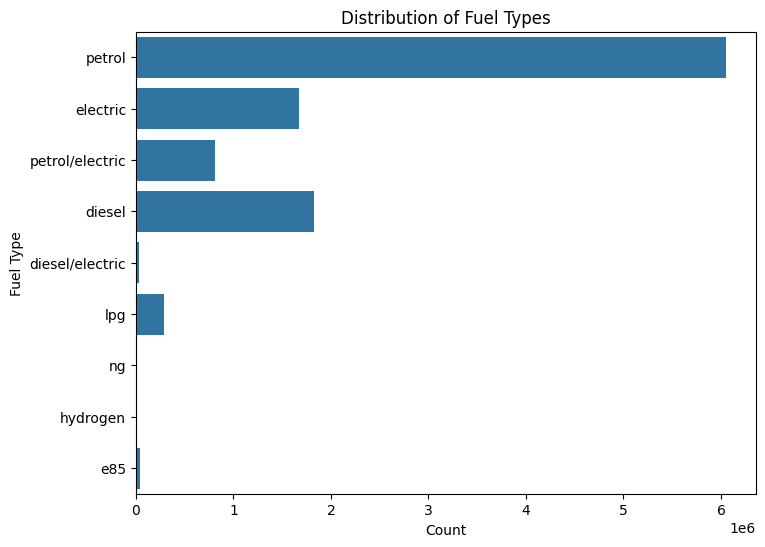

In [11]:
plt.figure(figsize=(8, 6))
sns.countplot(y="fuel_type", data=df)

plt.xlabel("Count")
plt.ylabel("Fuel Type")
plt.title("Distribution of Fuel Types")

Text(0.5, 1.0, 'Potential relationship of fuel_type to fuel_consumption')

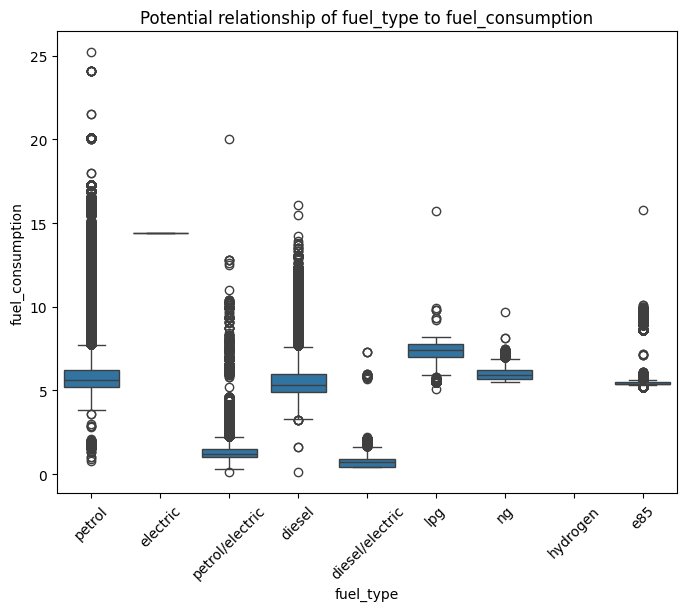

In [12]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="fuel_type", y="fuel_consumption", data=df)

plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("fuel_consumption")
plt.title("Potential relationship of fuel_type to fuel_consumption")

Text(0.5, 1.0, 'Potential relationship of fuel_type to specific_co2_emissions')

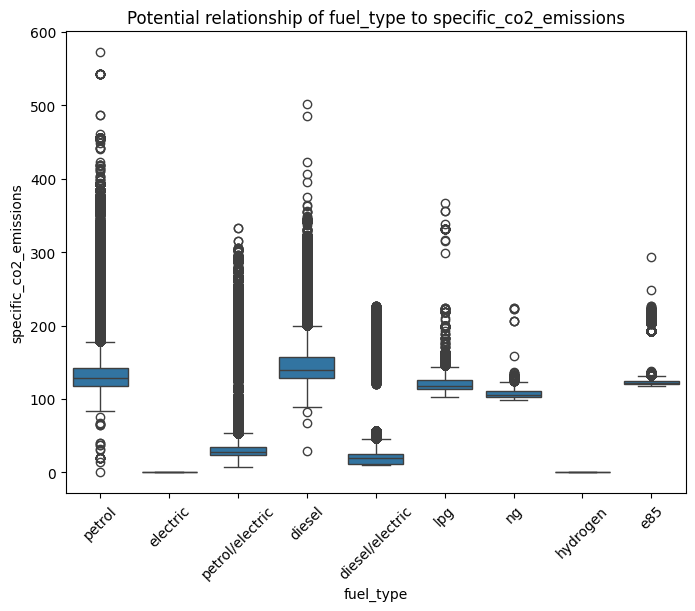

In [13]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="fuel_type", y="specific_co2_emissions", data=df)


plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("specific_co2_emissions")
plt.title("Potential relationship of fuel_type to specific_co2_emissions")

---> specific_co2_emissions for fuel_type electric and hydrogen are always 0
* check fuel_type electric against electric_energy_consumption

Text(0.5, 1.0, 'Potential relationship of electric fuel_type to electric_energy_consumption')

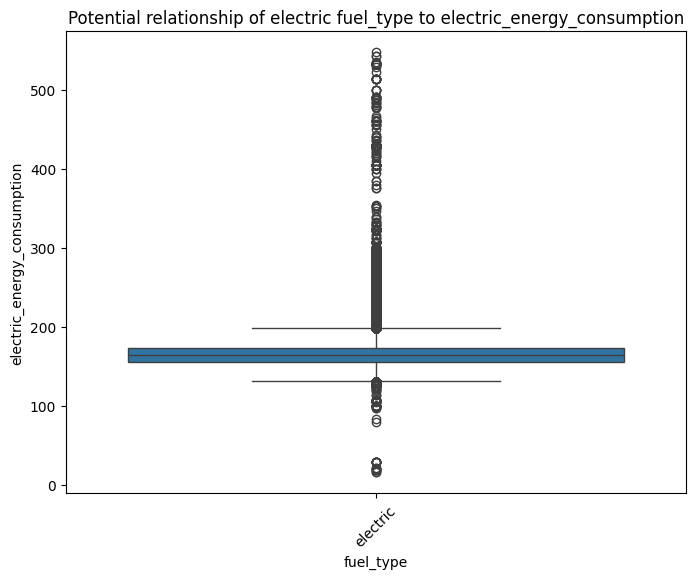

In [14]:
# take a deeper look into df_electric
df_electric = df[df["fuel_type"] == "electric"]


plt.figure(figsize=(8, 6))
sns.boxplot(x="fuel_type", y="electric_energy_consumption", data=df_electric)

plt.xticks(rotation=45)
plt.xlabel("fuel_type")
plt.ylabel("electric_energy_consumption")
plt.title("Potential relationship of electric fuel_type to electric_energy_consumption")

In [15]:
# check how many cars have fuel_type hydroen
hydrogen_count = len(df[df["fuel_type"] == "hydrogen"])
print(f"{hydrogen_count} cars with fuel_type hydrogen")

730 cars with fuel_type hydrogen


Remove hydrogen cars from our df as they are not representative

In [16]:
# drop rows with df["fuel_type"] == "hydrogen"
df = df[df["fuel_type"] != "hydrogen"]

## Split dataset into dataframe fuel type electric and dataframe with fuel types belonging to combustion engine category

### Cars with fuel_type electric

In [17]:
# check missing percentages of df_electric
print("Missing percentage for fuel_type == electric:")
print(df_electric.isna().sum() / len(df_electric))

Missing percentage for fuel_type == electric:
category_of_vehicle            0.005288
fuel_type                      0.000000
fuel_mode                      0.000000
mass_vehicle                   0.000037
weltp_test_mass                0.059688
engine_capacity                1.000000
engine_power                   0.026407
erwltp                         1.000000
year                           0.000000
electric_range                 0.027259
electric_energy_consumption    0.028529
fuel_consumption               0.999995
specific_co2_emissions         0.000005
dtype: float64


Remove variables that are useful for df_electric

In [18]:
df_electric["fuel_mode"].value_counts(normalize=True)


fuel_mode
E    1.0
Name: proportion, dtype: float64

In [19]:
# "fuel_type" not needed anymore as we only have fuel_type electric for now, same with fuel_mode
columns_to_analyse = ["category_of_vehicle", "mass_vehicle", "engine_power", "year", "electric_energy_consumption", "electric_range"]
df_electric = df_electric[columns_to_analyse]

#### Encoding

In [20]:
# encoding of categorical vars
cat_columns = pd.DataFrame.select_dtypes(df_electric, include=["object"]).columns
quant_columns = df_electric.select_dtypes(exclude=["object"]).columns

ct_electric = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), cat_columns)], remainder="passthrough")
transformed_array = ct_electric.fit_transform(df_electric)
encoder_feature_names = ct_electric.named_transformers_["encoder"].get_feature_names_out(cat_columns)

preserved_col_names = list(encoder_feature_names)
preserved_col_names.extend(list(quant_columns))

df_electric = pd.DataFrame(transformed_array, columns=preserved_col_names)

#### Calculate and analyse correlations

<Axes: >

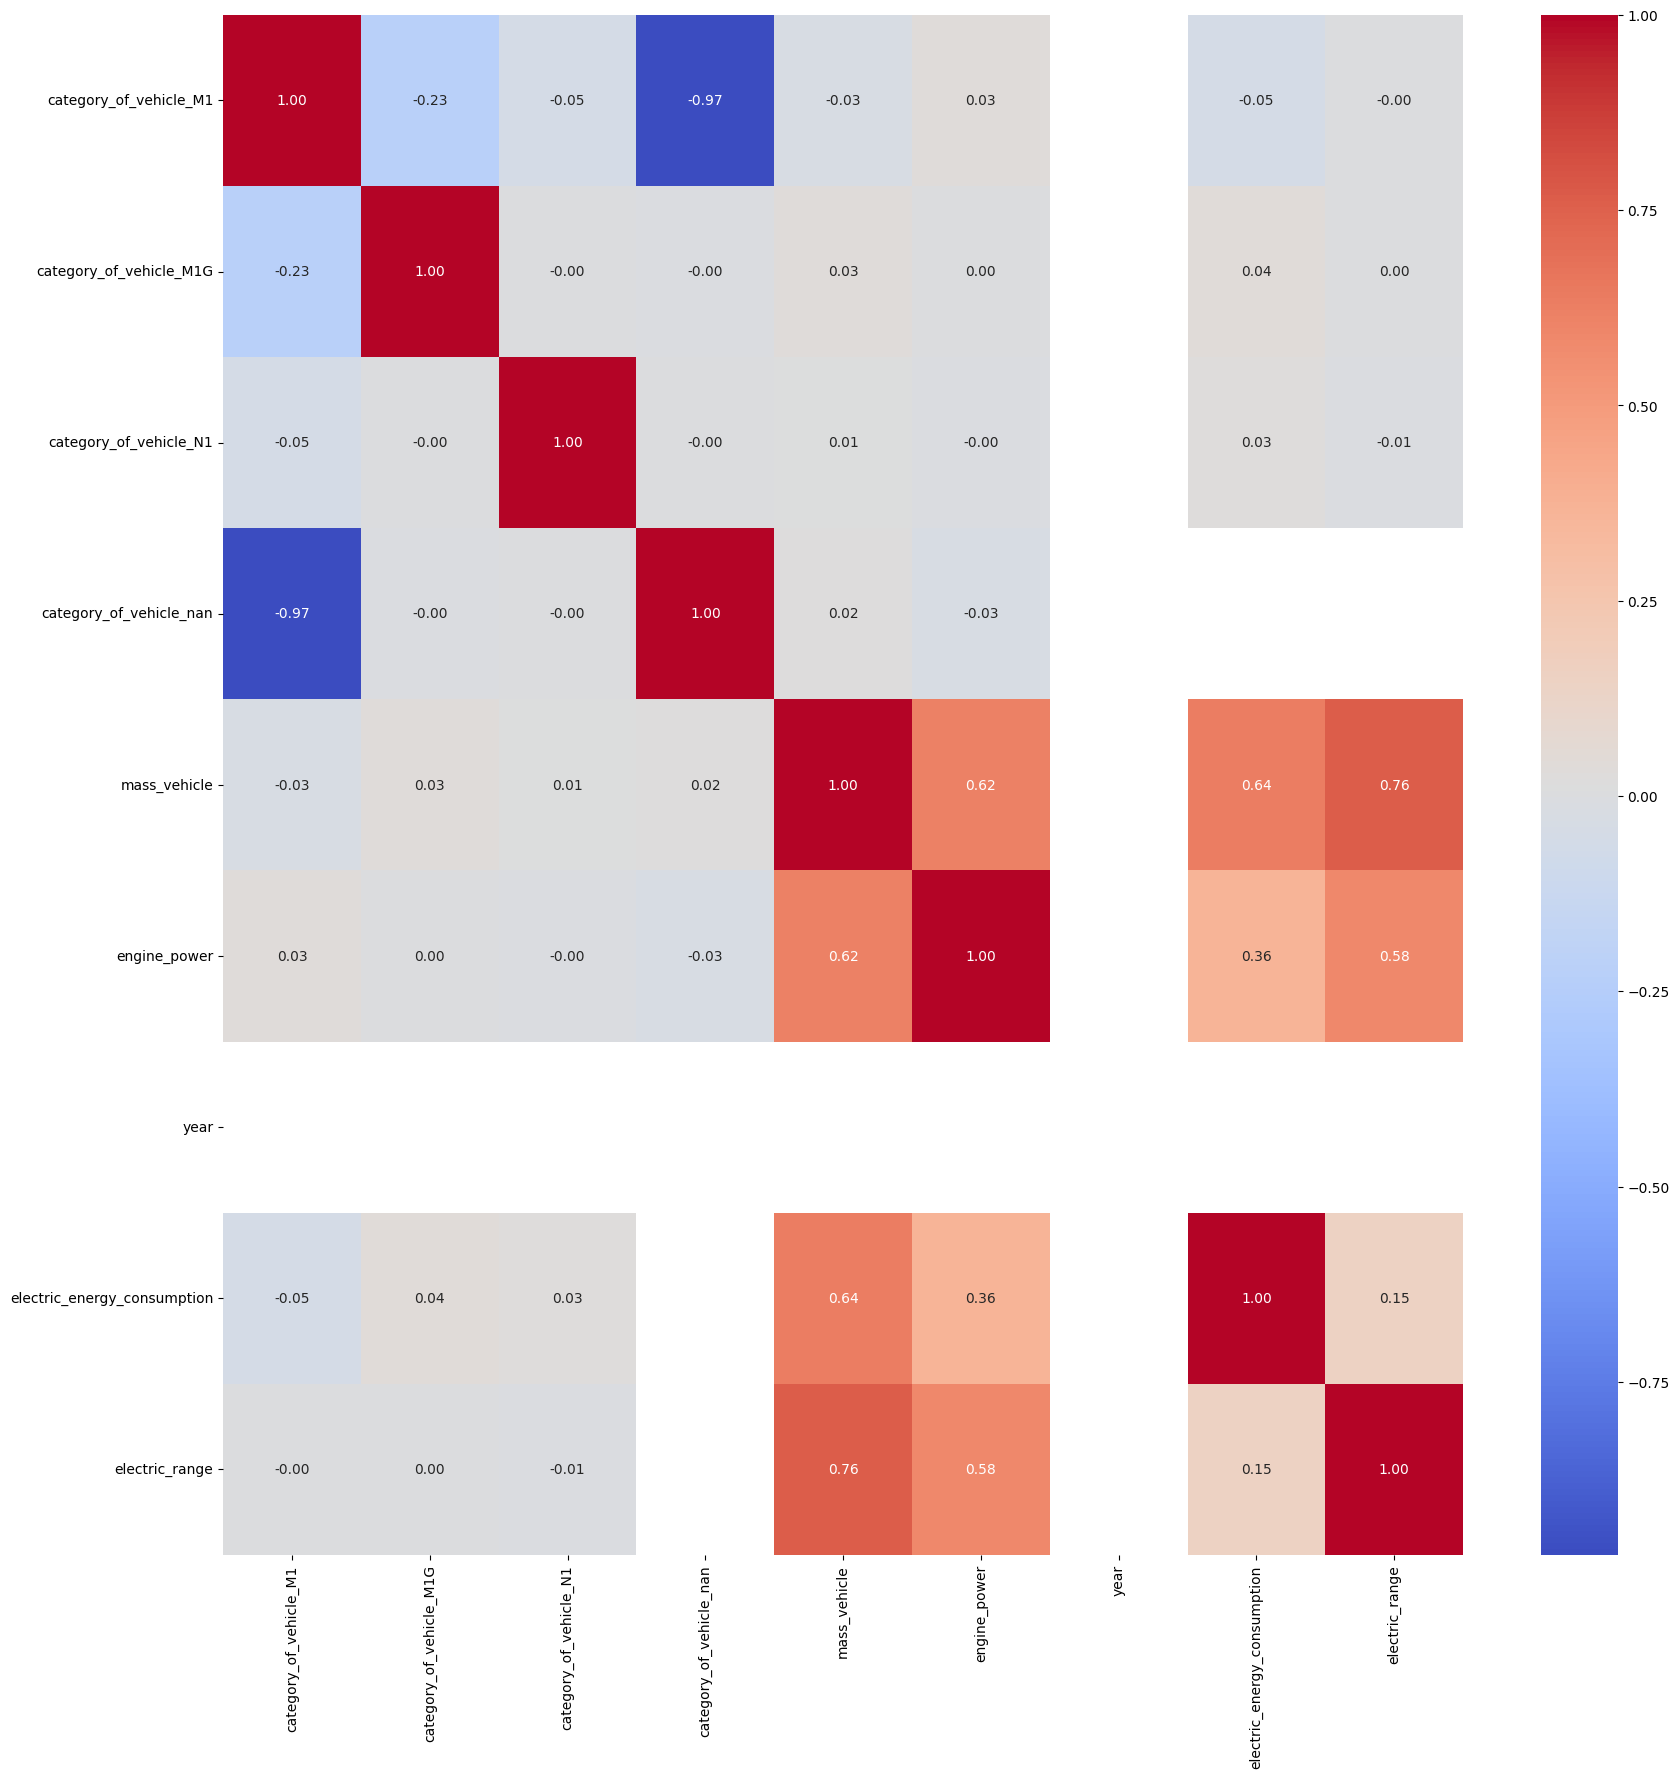

In [21]:
corr_matrix_electric = df_electric.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_electric, annot=True, cmap="coolwarm", fmt=".2f")

In [22]:
# check against target electric_energy_consumption
corr_table = df_electric.corr()["electric_energy_consumption"].sort_values(ascending=False)
print(corr_table)
export_path = OUTPUT_DIR + "/corr_table_electric_energy_consumption.csv"
corr_table.to_csv(export_path)

electric_energy_consumption    1.000000
mass_vehicle                   0.637126
engine_power                   0.363259
electric_range                 0.150685
category_of_vehicle_M1G        0.043927
category_of_vehicle_N1         0.025271
category_of_vehicle_M1        -0.048835
category_of_vehicle_nan             NaN
year                                NaN
Name: electric_energy_consumption, dtype: float64


### Cars with fuel_type belonging to combustion category

> All cars that are not electric
>
> consider hybrid petrol/electric and diesel/electric to belong to combustion category

In [23]:
# MAKE SURE to update fuel_types if other datasets have types we did not consider.
combustion_fuel_types = ["petrol", "diesel", "petrol/electric", "lpg", "e85", "diesel/electric", "ng"]
df_combustion = df[df["fuel_type"].isin(combustion_fuel_types)]

In [24]:
# check missing percentages of df_combustion
print("Missing percentage for fuel_type belonging to combustion:")
print(df_combustion.isna().sum() / len(df_combustion))

Missing percentage for fuel_type belonging to combustion:
category_of_vehicle            0.000484
fuel_type                      0.000000
fuel_mode                      0.000000
mass_vehicle                   0.000013
weltp_test_mass                0.006827
engine_capacity                0.000009
engine_power                   0.000729
erwltp                         0.233905
year                           0.000000
electric_range                 0.911225
electric_energy_consumption    0.910100
fuel_consumption               0.024163
specific_co2_emissions         0.001474
dtype: float64


Remove variables that are useful for df_combustion

In [25]:
columns_to_analyse = ["category_of_vehicle", "fuel_type", "mass_vehicle", "engine_capacity", "engine_power", "year", "fuel_consumption"]
df_combustion = df_combustion[columns_to_analyse]

#### Encoding

In [26]:
# encoding of categorical vars
cat_columns = pd.DataFrame.select_dtypes(df_combustion, include=["object"]).columns
quant_columns = df_combustion.select_dtypes(exclude=["object"]).columns

ct_combustion = ColumnTransformer(transformers=[("encoder", OneHotEncoder(), cat_columns)], remainder="passthrough")
transformed_array = ct_combustion.fit_transform(df_combustion)
encoder_feature_names = ct_combustion.named_transformers_["encoder"].get_feature_names_out(cat_columns)

preserved_col_names = list(encoder_feature_names)
preserved_col_names.extend(list(quant_columns))

df_combustion = pd.DataFrame(transformed_array, columns=preserved_col_names)

#### Calculate and analyse correlations

<Axes: >

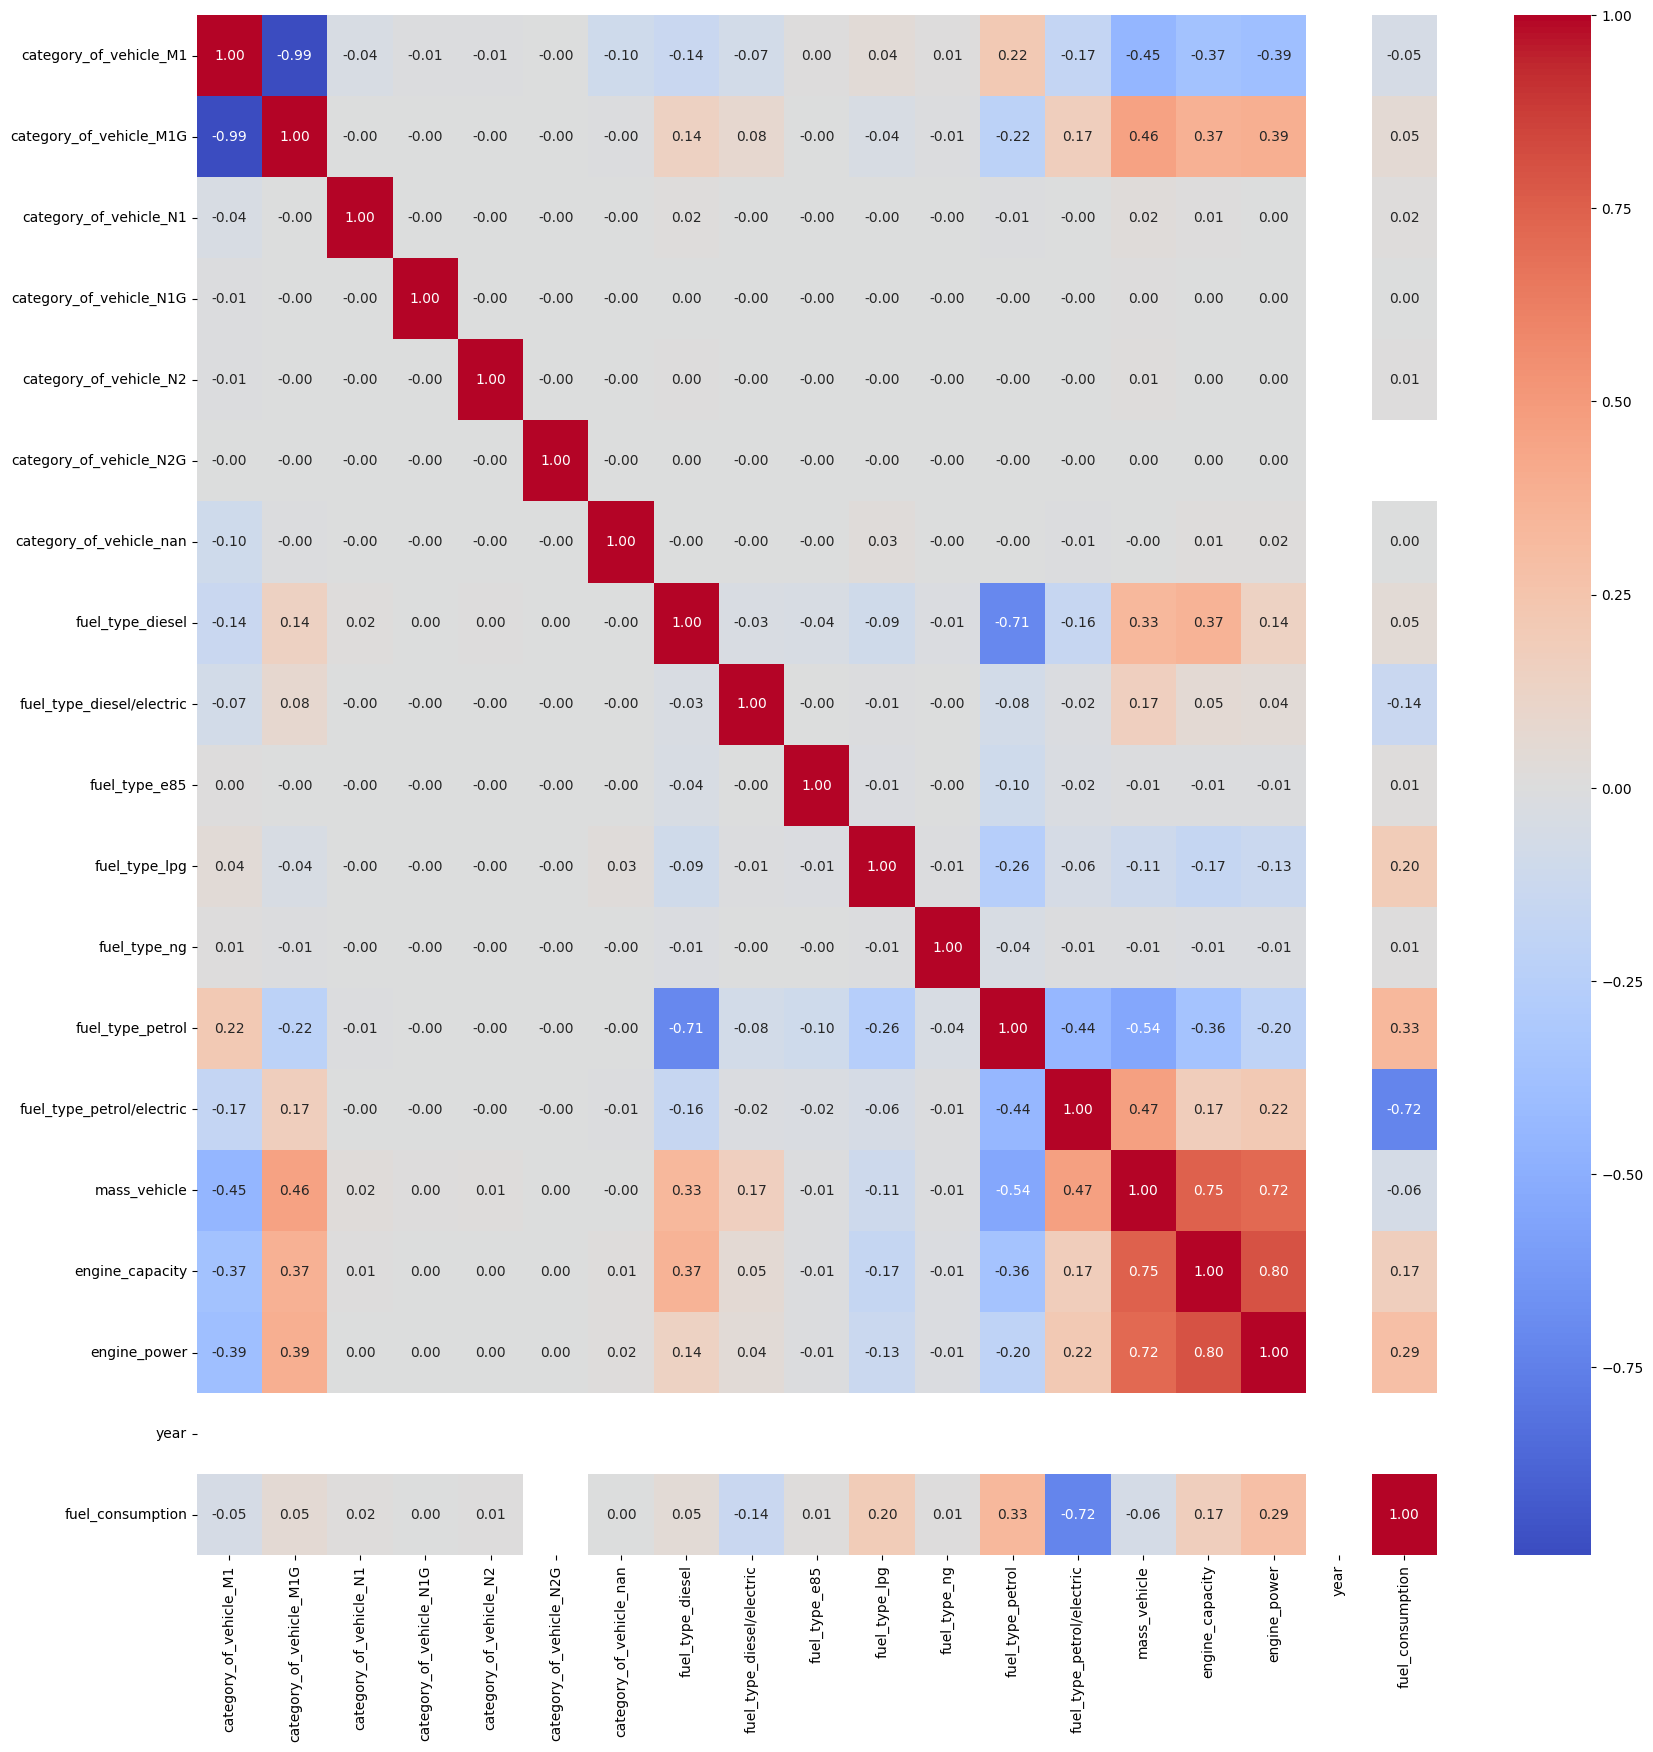

In [27]:
corr_matrix_combustion = df_combustion.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix_combustion, annot=True, cmap="coolwarm", fmt=".2f")

In [28]:
# check against target fuel_consumption
corr_table = df_combustion.corr()["fuel_consumption"].sort_values(ascending=False)
print(corr_table)
export_path = OUTPUT_DIR + "/corr_table_fuel_consumption.csv"
corr_table.to_csv(export_path)

fuel_consumption             1.000000
fuel_type_petrol             0.332563
engine_power                 0.289331
fuel_type_lpg                0.196725
engine_capacity              0.167810
category_of_vehicle_M1G      0.053517
fuel_type_diesel             0.049822
category_of_vehicle_N1       0.015425
fuel_type_e85                0.011613
category_of_vehicle_N2       0.009211
fuel_type_ng                 0.008595
category_of_vehicle_N1G      0.003040
category_of_vehicle_nan      0.002721
category_of_vehicle_M1      -0.054281
mass_vehicle                -0.064284
fuel_type_diesel/electric   -0.142624
fuel_type_petrol/electric   -0.723062
category_of_vehicle_N2G           NaN
year                              NaN
Name: fuel_consumption, dtype: float64
